In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

The main question I seek to explore in this project, is whether playing the computer-game *Counter Strike: Global Offensive* (CSGO) in the evening has an effect on the quality of my sleep. 

*But why assume that gaming has an effect?*

Because screen time during the evening exposes you to blue-light and according to sleep-experts - such as Matthew Walker, researcher and author of: *Why We Sleep* - blue-light impacts our sleep cycle. Additionally, CSGO is a highly intensive game where the question of doing well depends on quick reflexes. These two factors was reason enough for me to investigate whether there are any correlation between nightly gaming sessions and sleeping quality. Therefore I decided to stop playing computer games from the **2020-09-01** and going forward, to see if any significant change in sleep quality could be detected in my fitbit data. However, just as I stopped playing the weather conditions in Denmark started spiking and I recall having trouble falling asleep due to the heat, and thus I decided to also include weather-data from the Danish Meteological Institute (DMI) into the project.

**Data Sources:**
* Personal Fitbit Data
    * Sleep Data
    * Activity Data
* DMI weather data

**Challenges:**

The data is from the period **2020-05-02 - 2020-10-14** and whether there is a data point varies for each data source. This is mainly due to the fact that the fitbit data I downloaded has varying degrees of quality. For example, the physical data (periods of high heart rate and etc.), was packaged into both .JSON .csv and .txt files and the sheer amount of cleaning necessary to be done would be a big task. Therefore I gathered the data from a different part of the fitbit webpage, where it was possible to get the data as daily entries into a .csv file, however this was only possible to do for September and Oktober.


## 1. Data Wrangling


### 1.1 Read in Sleep Data

In [2]:
# Read in sleep data
df = pd.read_csv('data/MyFitbitData/AndreasHald/Sleep/sleep_score.csv')
# print(df.dtypes)
# df.head()

In [3]:
df['ymd'] = pd.to_datetime(df['timestamp']).dt.date
# df.head()

### 1.2 Read in Fitbit Physical Data

In [4]:
os.chdir('data/MyFitbitData/AndreasHald/Physical Activity/')

In [5]:
df_september = pd.read_csv('fitbit_export_september.csv', skiprows=1) # Skip column names
df_oktober = pd.read_csv('fitbit_export_oktober.csv', skiprows=1)

In [6]:
# df_activity = pd.concat([df_september, df_oktober]) # Join dataframes

In [7]:
df_activity = df_september.append(df_oktober)

In [8]:
df_activity['ymd'] = pd.to_datetime(df_activity['Date'], format='%d-%m-%Y').dt.date # Change to ymd (year month day)-order
# df_activity.dtypes

### 1.3 Read in DMI Weather data

In [9]:
import os

os.chdir('../../../WeatherData/Copenhagen/')

# os.chdir('data/WeatherData/Copenhagen/')

df_w = None

# Read in all the .csv files: 
for i, file in enumerate(os.listdir()):
    if i == 0:
        df_w = pd.read_csv(file, delimiter=';')
    else:
        df_tmp = pd.read_csv(file, delimiter=';')
        df_w = pd.concat([df_w, df_tmp])
        
df_w.sort_values('DateTime',inplace=True)

In [10]:
df_w['ymd'] = pd.to_datetime(df_w['DateTime']).dt.date
# df_w.head()

### 1.4 Merge all Data

In [11]:
df_master = pd.merge(df, df_w, on='ymd', how='left')
df_master = pd.merge(df_master, df_activity, on='ymd', how='left')

df_master.shape

(152, 24)

In [12]:
print(df.shape)
print(df_w.shape)
print(df_activity.shape)
print(df_master.shape)

(152, 10)
(305, 5)
(50, 11)
(152, 24)


In [13]:
df_master.rename(columns={'Højeste': 'Temperature'}, inplace=True) # Rename 'Højeste'. 

### 2: Explore

In [14]:
# Select specific relevant columns
df_using = df_master[['ymd', 
           'overall_score', 
           'deep_sleep_in_minutes', 
           'restlessness', 
#            'Laveste', 
#            'Middel', 
           'Temperature', 
           'Calories Burned', 
           'Steps',
           'Distance',
           'Minutes Sedentary',
           'Minutes Fairly Active',
           'Minutes Very Active',
          ]]

In [15]:
# Define 
stop_date = datetime.datetime.strptime('2020-09-01', '%Y-%m-%d').date()

In [16]:
df_using['game_night'] = df_using['ymd'] < stop_date

<AxesSubplot:>

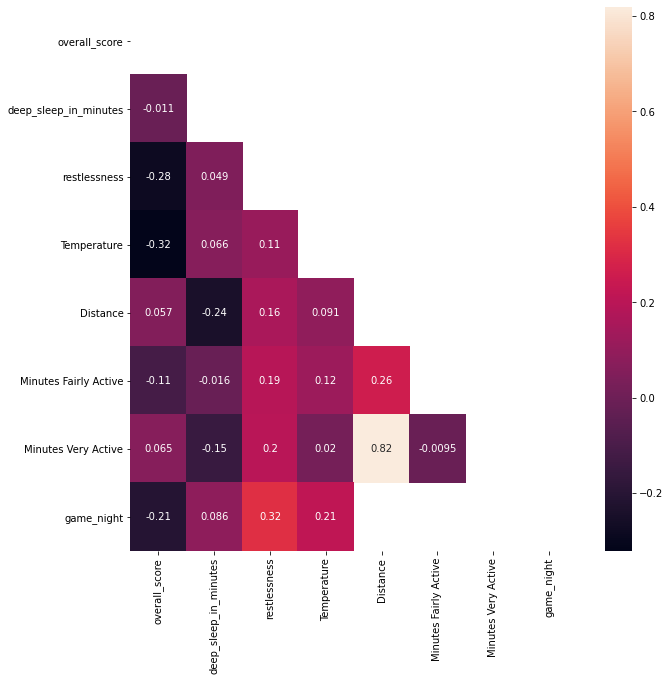

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
mask = np.zeros_like(df_using.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_using.corr(),annot=True, mask=mask)


#### Investigating Linear Correlation:

The heatmap above, shows no remarkable correlation interaction between the 3 datasets. While Distance and Minutes Very Active has a high positive correlation, this is expected, because the the longer I am active, the further I tend to travel in distance, and these are typically days that I go for a run and/or walk.

Nevertheless, there are some weak negative correlation between the columns "restlesness", "Temperature", "game_night" and "overall_score". Further there seems to be a weak positive correlation between "game_night" and "restlessness".

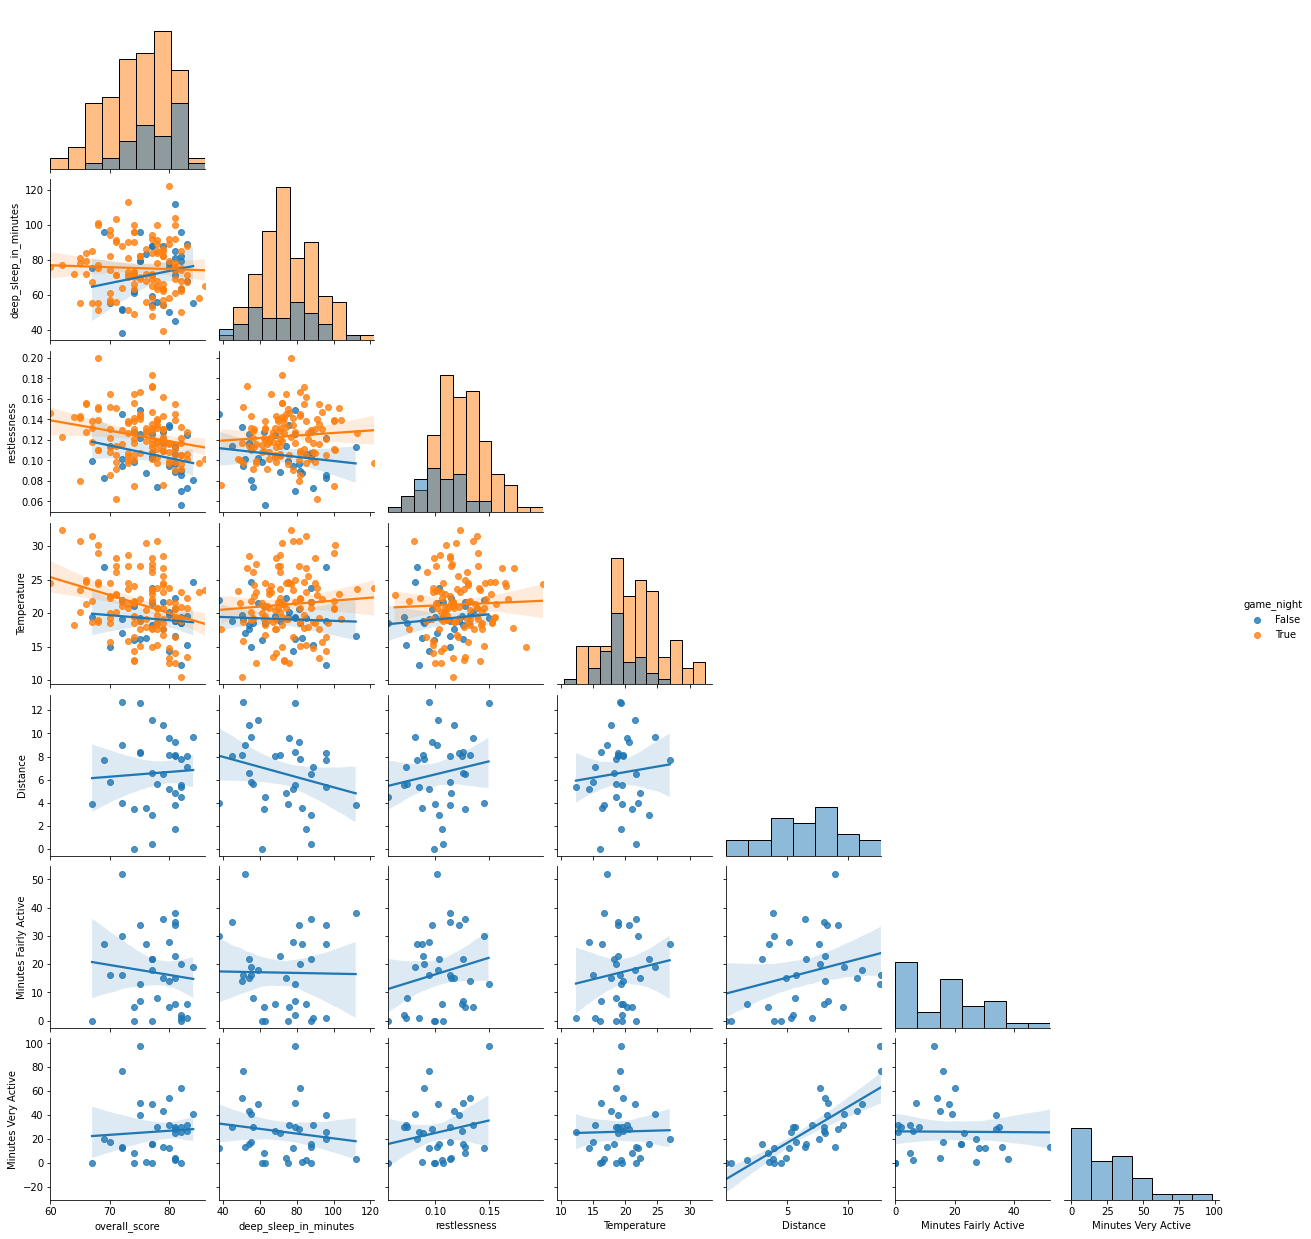

In [18]:
sns.pairplot(df_using,
             hue='game_night',
             diag_kind='hist',
             kind='reg',
             corner=True)

The correlations mentioned above, are arguably harder to spot on the preceding pairplot, partly because variance is high for most of the paired scatter plots and it is obvious that any linear regression model plotted over these variables would suffer from heteroscedasticity. 

One approach could be to try and remove extreme outliers from the variables and then try to reinvestigate the correlations. However, instead I want to briefly consider the 'overall_score'-variable and the general dynamics of my sleep pattern.

Generally, I have a pretty stable routine: to bed between 22:00-23:00, wake up at 6:30-7:30. But, I currently live in an apartment complex with rather noisy neighbours. However, their noise-patterns almost varies as much as the datapoints in the scatterlpot underneath and as such I suspect this add considerable noise to the data and as I have not kept track of when this occured, it is hard to account for in the data. 

<AxesSubplot:xlabel='ymd', ylabel='overall_score'>

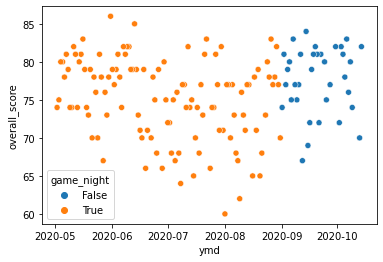

In [19]:
sns.scatterplot(x='ymd', y='overall_score', hue='game_night', data=df_using)

To counter this noise, I will instead convert the 'overall_score'-variable into a rolling average, and see if any larger pattern is more descernible in the data as a result:

In [20]:
# Sort values
df_using.sort_values(by='ymd', inplace=True)
# df_using

In [21]:
# Try rolling average
df_using['Temperature_rollavg'] = df_using['Temperature'].rolling(window=7).mean()
df_using['overall_score_rollavg'] = df_using['overall_score'].rolling(window=7).mean()
df_using['restlessness_rollavg'] = df_using['restlessness'].rolling(window=7).mean()

<AxesSubplot:xlabel='ymd', ylabel='Temperature'>

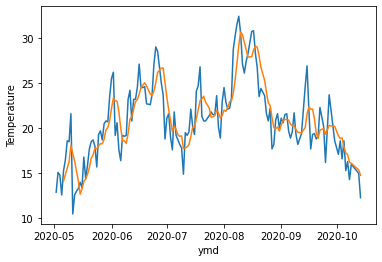

In [22]:
sns.lineplot(x=df_using['ymd'], y=df_using['Temperature'])
sns.lineplot(x=df_using['ymd'], y=df_using['Temperature'].rolling(window=5).mean())

In [23]:
# Try normalizing dataframe

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline

In [25]:
df_using[['overall_score', 
          'overall_score_rollavg',
          'Temperature_rollavg']] = minmax_scale(df_using[['overall_score', 'overall_score_rollavg','Temperature_rollavg']])

<AxesSubplot:xlabel='ymd', ylabel='overall_score_rollavg'>

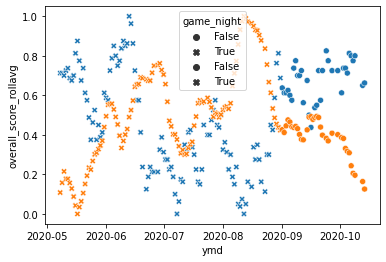

In [26]:
sns.scatterplot(x='ymd', y='overall_score_rollavg', data=df_using, style='game_night')
sns.scatterplot(x='ymd', y='Temperature_rollavg', data=df_using, style='game_night')

<AxesSubplot:>

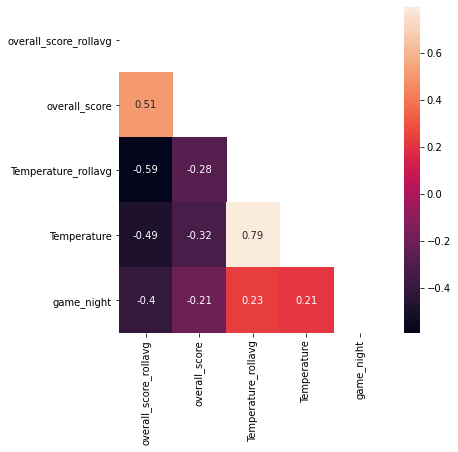

In [27]:
# df_tmp = df_using.loc[df_using['game_night'] == False]
df_tmp = df_using[['ymd','overall_score_rollavg', 'overall_score','Temperature_rollavg', 'Temperature', 'game_night']]


fig, ax = plt.subplots(figsize=(6,6))
mask = np.zeros_like(df_tmp.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_tmp.corr(),annot=True, mask=mask)


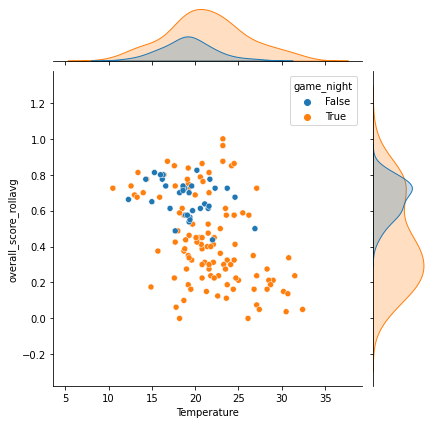

In [64]:
sns.jointplot(x='Temperature', y='overall_score_rollavg', data=df_using, hue="game_night")

In [29]:
df_tmp.reset_index(inplace=True)  # Get indexes that range from N-1, which is the wrong order.
df_tmp.drop('index', axis=1, inplace=True) # Drop index column
df_tmp.reset_index(inplace=True) # Get new indexes that range from 1-N in the right order.

In [35]:
# # sns.set()
# fig, ax = plt.subplots(figsize=(10,10))

# cmap='seismic'

# ax = sns.scatterplot(x='index', 
#            y='overall_score_rollavg', 
#            hue='Temperature', 
#            palette=cmap,
#            data=df_tmp)


# norm = plt.Normalize(df_tmp['Temperature'].min(), df_tmp['Temperature'].max())
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# ax.legend().remove()
# ax.figure.colorbar(sm)

# plt.show()

#### Investigate Linear Correlation in Rolling averages

In [31]:
from scipy import stats

df_gn = df_tmp.loc[df_tmp['game_night'] == True] #game night
df_ngn = df_tmp.loc[df_tmp['game_night'] == False] #not game night




df_list = [df_tmp, df_gn, df_ngn]
color = ['b', 'r', 'g']
titles = ['Complete Data', "Game Nights", "Non-Game Nights"]

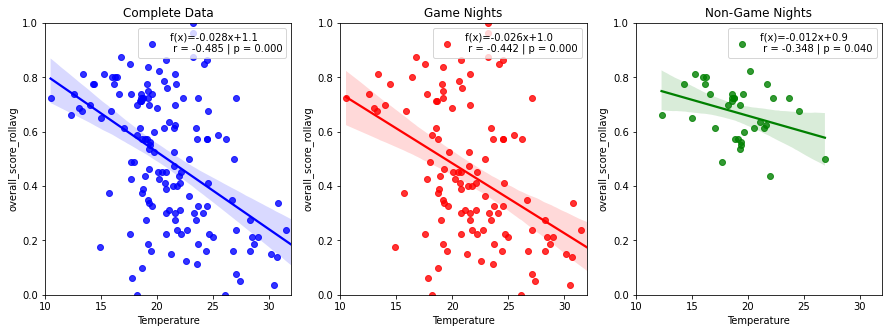

In [55]:
# df_tmp.reset_index(inplace=True)

fig, ax_ = plt.subplots(1,3, figsize=(15,5))

for i, df_ in enumerate(df_list):
    
    df_.dropna(inplace=True)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_['Temperature'], df_['overall_score_rollavg']) 
    
    sns.regplot(x='Temperature', 
                y='overall_score_rollavg', 
                data=df_, 
                color=color[i], 
                label="f(x)={:.3f}x+{:.1f} \n r = {:.3f} | p = {:.3f}".format(slope, intercept, r_value, p_value),
                ax=ax_[i]
               )
    ax_[i].legend()
    ax_[i].set_ylim(0, 1)
    ax_[i].set_xlim(10, 32)
    ax_[i].set_title(titles[i])
#     ax[]
    
#     ax[i].legen
#     ax[i].set_text("f(x)={0:.1f}x+{1:.1f}".format(slope, intercept))

#### Analysis of Covariance (ANCOVA):

The regression-line-plots above, show a clear correlation between "temparture" and the "overall_score_rollavg"- variable. But it also shows different slopes and intercepts for Game Nights and Non-Game Nights respectively. 

To test whether the difference is significant I will formulate a Null- and Alternative Hypothesis underneath and run an ANCOVA-analysis:

$H_0: $ The "game-night"-variable does not influence the "overall_score_rollavg"-variable, controlling for "Temperature"-variable.

$H_a: $ The "game-night"-variable does influence the "overall_score_rollavg"-variable, controlling for "Temperature"-variable.

In [62]:
from pingouin import ancova

ancova(data=df_tmp, dv='overall_score_rollavg', covar='Temperature', between='game_night')

,Source,SS,DF,F,p-unc,np2
0,game_night,0.694919,1,16.550424,7.798449e-05,0.103732
1,Temperature,1.365349,1,32.517616,6.529824e-08,0.185267
2,Residual,6.004280,143,NaN,NaN,NaN


#### Conclusion 

The ANCOVA test shows that both the "Temperature" and "game_night" variables has significant effects on the "overall_score_rollavg"-variable. Thus I can reject $H_0$ in favor of $H_a$. 

In other words, both Temperature and whether I have gamed on a given evening, has a large impact on my quality of sleep, according to my Fitbit-Watch.

#### Future Work: 

**Including Gaming Data and perhaps Daily Food Ingestion:** In the future I will attempt to include gaming data if I begin to play CSGO again (which I probably will). 

While there is a clear difference in quality of sleep, depending on whether I have gamed in the evening, the variance in Game Nights is much greater than in the Non-Game Nights. 
I suspect that the amount of games I win/lose and how much I win/lose by tend to impact the quality of my sleep. I say this, because I am admittedly a sore loser. Not the worst you will ever meet I reckon, but probably not the best either (Special apologies goes out to my friends and family).

**More finely granulated data:**
Secondly, I will attempt to gather more finely granulated data. For example, I would like to analyze the impact of the hourly temperature in my area, rather that a single estimate for the day. The highest temperatures during the day, does not necessarily mean that nightly temperatures are equally high, though they are probably correlated. 
More finely granulated data, could probably lead to clearer correlations and possibly disprove other assumptions.

